In [40]:
### Import packages and define functions and dictionaries

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import glob
from matplotlib.colors import ListedColormap
from scipy.spatial import cKDTree
from emagpy import Problem
import numpy as np
from math import floor, ceil
from scipy.stats import gmean
from math import sqrt, pi
import matplotlib
from matplotlib import colors
from numpy.polynomial import Polynomial as P
from scipy.interpolate import griddata

sys.path.append((os.path.relpath(r"C:\Users\Chris\Box\Rutgers Stuff\Research\EM_ERI Calibration Paper\EConflux\code")))
import er2em
import vse

dualemDict = {
    'PRP1.1': {
        '20%': 0.102*1.1,
        'ED': 0.289*1.1,
        'DOE': 0.490*1.1},
    'PRP2.1': {
        '20%': 0.102*2.1,
        'ED': 0.289*2.1,
        'DOE': 0.490*2.1},
    'HCP1.0': {
        '20%': 0.375*1.0,
        'ED': 0.866*1.0,
        'DOE': 1.590*1.0},
    'PRP4.1': {
        '20%': 0.102*4.1,
        'ED': 0.289*4.1,
        'DOE': 0.490*4.1},
    'HCP2.0': {
        '20%': 0.375*2.0,
        'ED': 0.866*2.0,
        'DOE': 1.590*2.0},
    'HCP4.0': {
        '20%': 0.375*4.0,
        'ED': 0.866*4.0,
        'DOE': 1.590*4.0}
    }

QtoIPconv = {
    'PRP1.1': 0.0215,
    'PRP2.1': 0.0783,
    'HCP1.0': 0.0178,
    'PRP4.1': 0.299,
    'HCP2.0': 0.0711,
    'HCP4.0': 0.284}

def build_log_depths(
    min_depth=0.1,
    max_depth=5.0,
    n_layers=20,
    power=1.0,
    min_thk=None,
    return_interfaces=True
):
    """
    Construct true log-spaced depth interfaces, with optional:
    - power-warping (power<1 = shallow concentration),
    - minimum layer thickness enforcement.
    """

    # ----------------------------------------------------------
    # 1) Generate normalized coordinates
    # ----------------------------------------------------------
    x = np.linspace(0.0, 1.0, n_layers)

    # ----------------------------------------------------------
    # 2) Apply the corrected power mapping
    # ----------------------------------------------------------
    xp = 1.0 - (1.0 - x)**power

    # ----------------------------------------------------------
    # 3) Generate true log spacing
    # ----------------------------------------------------------
    depths = np.exp(
        np.log(min_depth) + xp * np.log(max_depth / min_depth)
    )  # length n_layers+1

    # ----------------------------------------------------------
    # 4) Enforce minimum thickness if specified
    # ----------------------------------------------------------
    if min_thk is not None:

        # First compute thicknesses
        thk = np.diff(depths)

        # If *all* thicknesses exceed min_thk → nothing to do
        if np.all(thk >= min_thk):
            pass
        else:
            # Total thickness budget (fixed)
            total_depth = depths[-1] - depths[0]

            # Number of layers
            L = n_layers

            # Minimum total thickness if all layers set to min_thk
            min_total = L * min_thk

            if min_total > total_depth:
                raise ValueError(
                    f"Minimum thickness min_thk={min_thk} is too large; "
                    f"total depth {total_depth:.3f} cannot accommodate {L} layers."
                )

            # Normalize original thicknesses to distribute excess depth
            thk_modified = thk.copy()

            # Identify layers that violate the minimum
            thin_idx = thk_modified < min_thk

            # Set those to minimum thickness
            thk_modified[thin_idx] = min_thk

            # Remaining thickness budget
            remaining = total_depth - np.sum(thk_modified)

            # Distribute remaining proportionally to original thickness distribution
            if remaining > 0:
                # Only layers originally above minimum receive extra proportionally
                thick_idx = ~thin_idx
                w = thk[thick_idx]
                if np.sum(w) == 0:
                    # fallback: distribute evenly
                    thk_modified[thick_idx] += remaining / np.sum(thick_idx)
                else:
                    thk_modified[thick_idx] += remaining * (w / np.sum(w))

            # Rebuild interface depths
            depths = np.concatenate([[min_depth], min_depth + np.cumsum(thk_modified)])

    # ----------------------------------------------------------
    # 5) Return interface depths OR thicknesses
    # ----------------------------------------------------------
    if return_interfaces:
        return depths
    else:
        return np.diff(depths)

def interpolate_nans(x, z, values):
    nan_mask = np.isnan(values)
    if np.any(nan_mask):  
        valid_points = ~nan_mask
        points = np.column_stack((x[valid_points], z[valid_points]))  
        values_known = values[valid_points]  
        values[nan_mask] = griddata(points, values_known, (x[nan_mask], z[nan_mask]), method='cubic')
        if np.any(np.isnan(values)):  
            values[nan_mask] = griddata(points, values_known, (x[nan_mask], z[nan_mask]), method='cubic')
    return values

# Function to generate contour plot
def plot_contour(ax, x, z, values, vmin, vmax, title=None, xmin=None, xmax=None, cbbool=True, dist=True, cmap='plasma', cbTicks=None, cbLabel=None, ri=None, riThresh=None, zbounds=None, numZtick=5, subfig=None, subfig2=None, contourOrSmooth='smooth', plotMeas=False, measPoints=None):

        grid_x = np.linspace(x.min(), x.max(), 200)
        grid_z = np.geomspace(z.min(), z.max(), 200)
        grid_X, grid_Z = np.meshgrid(grid_x, grid_z)
    
        grid_values = griddata((x, z), values, (grid_X, grid_Z), method='linear')
        
        if ri is not None:
            
            grid_mask = griddata((x, z), ri, (grid_X, grid_Z), method='linear')
    
            if 'DOI Flag' in ri.name:
                grid_mask = np.round(grid_mask)
                grid_mask = np.ma.masked_where(grid_mask > 0, grid_mask)
            else:
                grid_mask = np.ma.masked_where(grid_mask >  riThresh, grid_mask)
            
            grid_values = np.ma.masked_where(grid_mask.mask, grid_values)
    
        if contourOrSmooth == 'contour':
            contour = ax.contourf(grid_X, grid_Z, grid_values, norm=colors.LogNorm(vmin=vmin, vmax=vmax), levels=np.geomspace(vmin, vmax, 40), cmap=cmap)
        elif contourOrSmooth == 'smooth':
            contour = ax.pcolormesh(grid_X, grid_Z, grid_values, norm=colors.LogNorm(vmin=vmin, vmax=vmax), shading='gouraud', cmap=cmap)
       
        # Add scatter points on top of contour
        if plotMeas:
            if measPoints is not None:
                ax.scatter(measPoints.iloc[:, 0], measPoints.iloc[:, 1], color='white', edgecolor='black', s=0.05, zorder=10, label='Measurement Locations')
            else:
                ax.scatter(x, -1*z, color='white', edgecolor='black', s=0.05, zorder=10, label='Measurement Locations')
            ax.legend()
    
        if cbbool:
            cbar = plt.colorbar(contour, ax=ax, location='bottom', aspect=25, fraction=0.15, pad=0.3)
            if cbLabel is not None:
                cbar.set_label(cbLabel, fontsize=20, fontweight='bold')
            else:
                cbar.set_label(values.name, fontsize=20, fontweight='bold')
                
            if cbTicks is not None:
                cbar.set_ticks(cbTicks)
                cbar.set_ticklabels([str(t) for t in cbTicks])  # Format as strings
                cbar.ax.tick_params(labelsize=18)
        ax.set_xlabel('Distance Along ERI Line (m)' if dist else 'Length (m)', fontsize = 25, fontweight='bold')
        ax.set_ylabel('Depth (m)', fontsize = 25, fontweight='bold')
        if title is not None:
            ax.set_title(title, fontsize = 25, pad=30)
        if zbounds is not None:
            ax.set_ylim(zbounds[0], zbounds[1])
            ax.set_yticks(np.linspace(zbounds[0], zbounds[1], numZtick))
        else:
            ax.set_ylim(0, z.max())
            ax.set_yticks(np.linspace(0, z.max(), numZtick))
        ax.invert_yaxis()
        if subfig:
            ax.annotate(subfig, xy=(0.005, 1.1), xycoords="axes fraction", fontsize=20, color='black', bbox=dict(facecolor="white", alpha=0.8, edgecolor='black'))
        if subfig2:
            ax.annotate(subfig2, xy=(0.038, 1.09), xycoords="axes fraction", fontsize=20, color='black')
        if (xmin is not None) & (xmax is not None):
            ax.set_xlim(xmin, xmax)  
        ax.tick_params(axis='both', which='major', labelsize=20)
            # Make border (spines) thicker
        for spine in ax.spines.values():
            spine.set_linewidth(2.0)
        return grid_values


def direct_local_grid_to_utm_along_line(local_grid_df, coord_list, polyDeg=3, numSamples=1000, lineLength=95, correctCoords=False, checkLine=False, saveElec=False, elecPath=None):
    
    if (max(coord_list['x']) - min(coord_list['x'])) > (max(coord_list['y']) - min(coord_list['y'])):
        func = P.fit(coord_list['x'], coord_list['y'], polyDeg)
        xx, yy = func.linspace(len(coord_list))
        sampX, sampY = func.linspace(numSamples)
        if checkLine:
            plt.plot(coord_list['x'], coord_list['y'], 'o', label='Original Points')
            plt.plot(xx, yy, lw=2, label='Interpolated Line')
            plt.gca().set_aspect('equal')
            plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
            plt.show()
            plt.close()
    else:
        func = P.fit(coord_list['y'], coord_list['x'], polyDeg)
        yy, xx = func.linspace(len(coord_list))
        sampY, sampX = func.linspace(numSamples)
        if checkLine:
            plt.plot(coord_list['y'], coord_list['x'], 'o', label='Original Points')
            plt.plot(yy, xx, lw=2, label='Interpolated Line')
            plt.gca().set_aspect('equal')
            plt.legend(loc='upper right', bbox_to_anchor=(1, 1.6))
            plt.show()
            plt.close()
    
    if correctCoords:
        coord_list['x'], coord_list['y'] = xx, yy
    
    linePos = np.zeros(numSamples)
    linePos = np.sqrt((sampX**2)+(sampY**2))
    if linePos[0] > linePos[-1]:
        relLinePos = abs((linePos - max(linePos)) / (max(linePos)-min(linePos)))
    else:
        relLinePos = (linePos - min(linePos)) / (max(linePos)-min(linePos))
    relLinePos *= lineLength
    
    elecDf = pd.DataFrame(np.transpose([relLinePos, np.zeros(numSamples)]), columns=['x', 'z'])
    
    tree = cKDTree(elecDf[['x', 'z']])
    dist, idx = tree.query(resInvDat[['X', 'Z']])

    for i in range(0, len(local_grid_df)):
        local_grid_df.loc[i, ['x', 'y']] = [sampX[idx[i]], sampY[idx[i]]]

    if saveElec:
        coord_list.to_csv(elecPath + 'corrElecCoords.csv', index=False)
        
    return local_grid_df


In [2]:
### Set font properties

titleFontKws = {
    'fontsize': 14,
    'fontweight': 'bold',
    }

subtitleFontKws = {
    'fontsize': 12,
    'fontweight': 'bold',
    }

labelFontKws = {
    'fontsize': 12,
    'fontweight': 'bold',
    }

tickLabelFontKws = {
    'labelsize': 9,
    }

cbarTitleKws = {
    'fontsize': 10,
    'fontweight': 'bold'}

cbarTickKws = {
    'fontsize': 8,
    }

plt.rcParams['font.weight'] = 'bold'

In [18]:
site = 'va_ag'

datDir = r'C:\Users\Chris\Box\Rutgers Stuff\Research\EM_ERI Calibration Paper\EConflux\examples\va_ag_er2em\\'

ertname = 'va_ag_invResult.dat'
eminame = 'va_ag_MH_invready_inph_noconvert_rECa.csv'
elecname = 'va_ag_elec_resipy.csv'

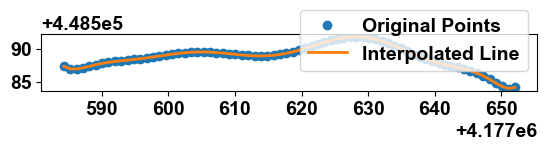

,X,Z,Linear Resistivity,Log Resistivity,Conductivity(mS/m),x,y
0,28.1770,-2.33420,12.5350,1.09810,79.776625,448589.058910,4.177611e+06
1,28.2560,-1.96850,11.4110,1.05730,87.634738,448589.052584,4.177611e+06
2,28.0030,-2.02840,11.2590,1.05150,88.817835,448589.078318,4.177611e+06
3,28.1450,-2.11030,11.7050,1.06840,85.433575,448589.065310,4.177611e+06
4,10.0490,-0.26289,2.6685,0.42627,374.742365,448588.264197,4.177594e+06
...,...,...,...,...,...,...,...
12930,13.0810,-0.66693,3.8076,0.58065,262.632629,448588.591292,4.177597e+06
12931,9.2146,-8.88830,17.3630,1.23960,57.593734,448588.187567,4.177593e+06
12932,9.2212,-8.33830,16.9390,1.22890,59.035362,448588.187567,4.177593e+06
12933,8.8141,-8.44950,16.6340,1.22100,60.117831,448588.144261,4.177593e+06


In [19]:
######### EM INVERSION ###########

emHgt = 0.1    # If you have an estimate for the height that the EM instrument was carried at during the survey, put it here
coilHgt = emHgt + 0.045   # Add 4.5 cm to the EM height to account for the coil arrays being centered in the boom of the DualEM

# Import your EMI data in the same format as expected from emagpy.
eca = pd.read_csv(datDir + eminame)
elec = pd.read_csv(elecname)
resInvDat = pd.read_csv(datDir + ertname, sep=' ', header=None, names=['X', 'Z', 'Linear Resistivity', 'Log Resistivity'], skipinitialspace=True)
resInvDat['Conductivity(mS/m)'] = (1 / resInvDat['Linear Resistivity']) * 1000

# Define  path to a folder for storing stuff
path = datDir

# Define variable filenames for each DataFrame
filename_ec = 'df_ec.csv'
filename_eca = 'df_eca.csv'

if coilHgt < 0.5:
    ecaCols = ['HCP1.0', 'PRP1.1', 'HCP2.0', 'PRP2.1', 'HCP4.0', 'PRP4.1']
elif coilHgt < 1.0:
    ecaCols = ['HCP1.0', 'HCP2.0', 'PRP2.1', 'HCP4.0', 'PRP4.1']

xyData_UTM = direct_local_grid_to_utm_along_line(resInvDat, elec, polyDeg=10, lineLength=71, correctCoords=True, checkLine=True, saveElec=True, elecPath=datDir)

xyData_UTM

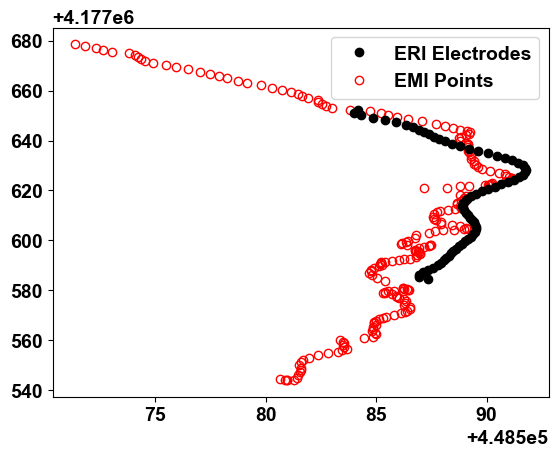

In [20]:
plotERTandEMI = True

if plotERTandEMI:
    plt.plot(elec['x'], elec['y'], 'o', color='k', label='ERI Electrodes', zorder=1)
    plt.plot(eca['x'], eca['y'], 'o', color='r', mfc='none', label='EMI Points', zorder=0)
    plt.legend()

''' You can add more than one data set to dflist. This means you can map multiple georeferenced measurements to the same grid. 
The grid can be defined by any dataset as well. For example, I can map all electrical measurements to locations of wells or 
locations where soil property observations.'''
dflist = [eca]
dfnames = ['']
if coilHgt < 0.5:
    ecaCols = ['HCP1.0', 'PRP1.1', 'HCP2.0', 'PRP2.1', 'HCP4.0', 'PRP4.1']
elif coilHgt < 1.0:
    ecaCols = ['HCP1.0', 'HCP2.0', 'PRP2.1', 'HCP4.0', 'PRP4.1']

'''num_neigbors - how many neighboring points will be mapped to target position
   max_distance - maximum distance to look for mappable points'''
mapper = er2em.DataMapper(num_neighbors=3, max_distance_xy=2, max_distance_z=0.5, ckdMethod='auto')

'''result_xy - merged target and mapped data into a single data frame.
   distances_xy - displacement of each mapped point. shape = length result_xy * num_neighbors'''
result_xy, distances_xy = mapper.mapXY(xyData_UTM, dflist, dfnames)

for coil in dualemDict.keys():
    for depth in dualemDict[coil].keys():
        dualemDict[coil][depth] -= coilHgt

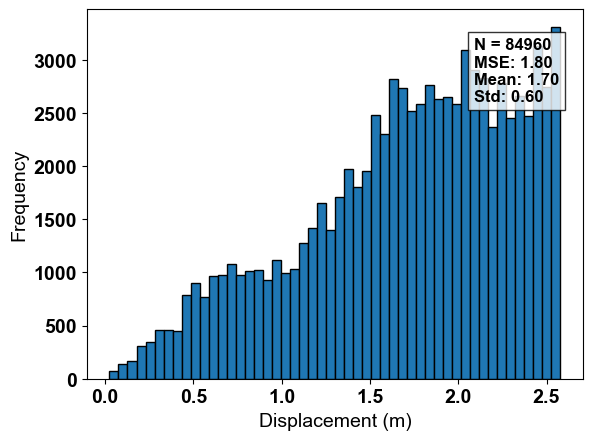

,X,PRP1.1,PRP2.1,HCP1.0,PRP4.1,HCP2.0,HCP4.0
0,28.1770,18.908603,50.568746,59.382465,62.302508,67.018305,66.758499
1,28.2560,18.908603,50.568746,59.382465,62.302508,67.018305,66.758499
2,28.0030,18.908603,50.568746,59.382465,62.302508,67.018305,66.758499
3,28.1450,18.908603,50.568746,59.382465,62.302508,67.018305,66.758499
4,10.0490,189.268120,231.610599,230.506678,192.207779,185.872099,144.352292
...,...,...,...,...,...,...,...
12930,13.0810,143.532071,190.860119,193.014668,170.578360,166.938346,132.212682
12931,9.2146,194.747272,236.491031,235.366619,195.936565,185.288421,149.940769
12932,9.2212,194.747272,236.491031,235.366619,195.936565,185.288421,149.940769
12933,8.8141,197.187671,237.605900,234.337857,196.181199,184.260797,151.605822


In [23]:
'''Split result_xy into three dataframes - arithmetic, geometric, harmonic'''
# Assume `result_xy` from mapXY or `result_xyz` from mapXYZ contains mean columns
df_arth, df_geom, df_harm = mapper.create_mean_dfs(result_xy)
mapper.plot_distance_histogram(distances_xy, xyAnn = (0.78, 0.75))
eca_df = mapper.filter_and_rename(df_geom, minCut=2, maxCut=2, MaxECa=1000, minECa=1, keepInphase=False)
eca_df

In [24]:
interpMethod1 = 'nearest'
interpMethod2 = 'linear'
interpMethod3 = 'cubic'
mapper.process_and_bin_data(eca_df, result_xy, path, filename_ec, filename_eca, nbins=175, xDis=0.1, zLayers=18, interpMethod=interpMethod1, useGeomspace=False) # zLayers should be anticipated number of EM layers

Initial length ECa 12299
Initial length EC 12935
3.927575507639134
After crop length ECa 12299
After crop length EC 12307
After meshing length ECa 12299
After meshing length EC 12060
After binning length ECa 175
After binning length EC 175


(     PRP1.1  PRP2.1  HCP1.0  PRP4.1  HCP2.0  HCP4.0
 0     191.6   273.6   269.7   241.3   248.5   174.2
 1     188.0   270.8   266.2   241.6   253.9   177.0
 2     187.4   263.7   262.5   242.2   257.4   182.9
 3     181.8   247.3   264.9   241.0   252.9   196.8
 4     178.6   242.6   265.5   239.7   248.3   201.2
 ..      ...     ...     ...     ...     ...     ...
 170     5.0     8.7    15.1     9.0    10.9    15.3
 171     5.0     8.8    15.1     9.0    10.8    15.3
 172     5.1     8.8    15.1     9.0    10.9    15.2
 173     5.1     8.8    15.2     9.0    10.9    15.2
 174     5.2     8.9    15.2     9.1    10.9    15.2
 
 [175 rows x 6 columns],
       d0.030   d0.650   d1.260   d1.880   d2.490   d3.110   d3.730   d4.340  \
 0    441.945  379.185  280.048  234.675  196.938  167.970  145.872  134.510   
 1    430.688  379.325  276.898  222.295  190.650  164.605  143.615  126.617   
 2    446.253  372.247  274.343  217.920  188.210  161.450  139.803  124.850   
 3    449.482  37

PRP1.1: ECa (ERT) = 1.36 * ECa (EMI) +0.03 (R^2=0.82)
PRP2.1: ECa (ERT) = 1.26 * ECa (EMI) -0.30 (R^2=0.93)
HCP1.0: ECa (ERT) = 1.56 * ECa (EMI) -0.96 (R^2=0.95)
PRP4.1: ECa (ERT) = 1.12 * ECa (EMI) -0.18 (R^2=0.96)
HCP2.0: ECa (ERT) = 1.08 * ECa (EMI) -0.26 (R^2=0.96)
HCP4.0: ECa (ERT) = 1.16 * ECa (EMI) -0.54 (R^2=0.96)
Correction is applied.
PRP1.1: ECa (ERT) = 0.61 * ECa (EMI) +1.13 (R^2=0.87)
PRP2.1: ECa (ERT) = 0.78 * ECa (EMI) +0.58 (R^2=0.89)
HCP1.0: ECa (ERT) = 0.75 * ECa (EMI) +0.57 (R^2=0.90)
PRP4.1: ECa (ERT) = 0.81 * ECa (EMI) +0.43 (R^2=0.92)
HCP2.0: ECa (ERT) = 0.85 * ECa (EMI) +0.27 (R^2=0.94)
HCP4.0: ECa (ERT) = 0.85 * ECa (EMI) +0.20 (R^2=0.92)
Correction is applied.
0/214 data removed (filterRange).
dataset shrunk of 9 measurements


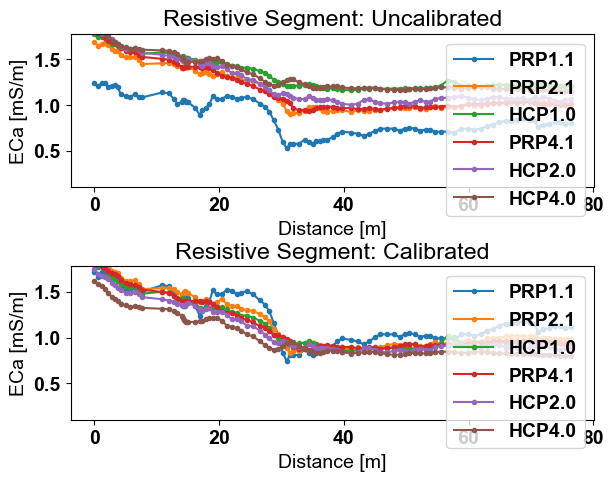

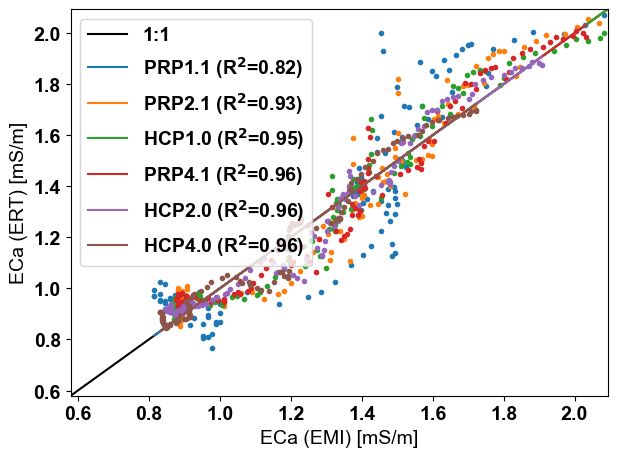

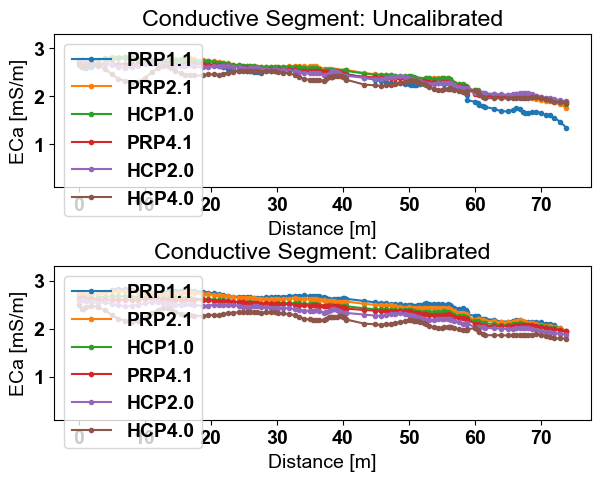

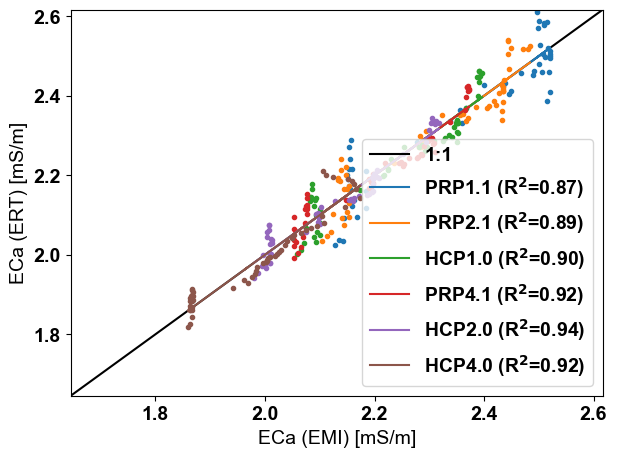

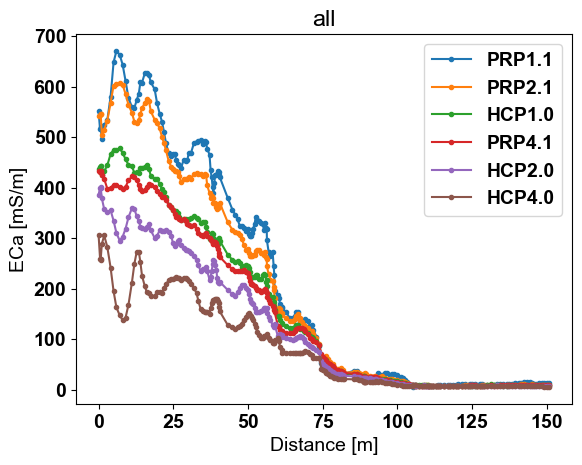

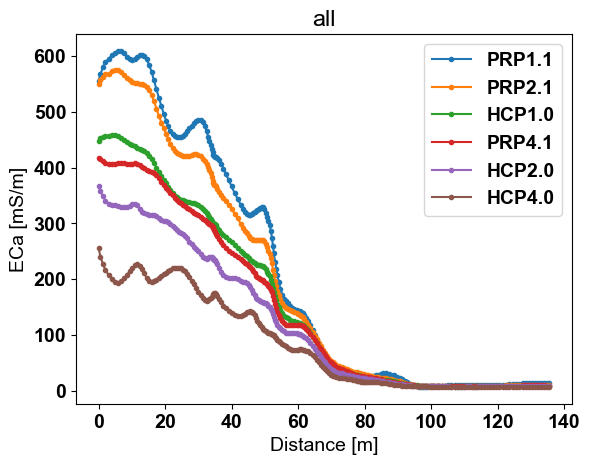

In [25]:
### Variable Definitions

filtRange = [2, 2000]   # Filter ECa
filtPct = False
calcQ = False # Whether or not you want to convert the ECa values from the calibrated EM dataset into ppt and bring that back into a new EMagPy survey
splitCal = True
splitMethod = 'LIN' # Define if you want to split the survey via 'ERT mean', 'EMI mean', 'LIN', or by None
EcaSplit = 20 # Define a value if not using a specific splitMethod
linThresh = 0.1 # If splitting surveys using EcaSplit = 'LIN', define what value you wish to use for your LIN threshold
mesh = 'quad' # Type of mesh used in resistivity model. Has to be defined regardless of whether or not resistivity model file is specified
rollWindow = 10
calLog = True
f_prefix = site + '_emi'

### Code

ECa = os.path.join(path, filename_eca)
EC = os.path.join(path, filename_ec)

if calLog:
    ecaLog = pd.read_csv(ECa)
    for col in ecaLog.columns:
        if '_inph' not in col:
            ecaLog[col] = np.log10(ecaLog[col])
        else:
            ecaLog.drop(columns=col, inplace=True)
    ecaLog.to_csv(path + '\\' + filename_eca[:-4] + '_log.csv', index=False)
    
    ecLog = np.log10(pd.read_csv(EC))
    ecLog.to_csv(path + '\\' + filename_ec[:-4] + '_log.csv', index=False)
    
    for col in eca.columns[2:]:
        if '_inph' not in col:
            eca[col] = np.log10(eca[col])

if coilHgt < 0.5:
    coils = ['PRP1.1', 'PRP2.1', 'HCP1.0', 'PRP4.1', 'HCP2.0', 'HCP4.0']
elif coilHgt < 1.0:
    coils = ['PRP2.1', 'HCP1.0', 'PRP4.1', 'HCP2.0', 'HCP4.0']
elif coilHgt < 1.6:
    coils = ['HCP1.0', 'PRP4.1', 'HCP2.0', 'HCP4.0']
    
if splitCal:
    
    if splitMethod == 'ERT mean':
        EcaSplit = gmean(xyData_UTM['Conductivity(mS/m)'].values)
    elif splitMethod == 'EMI mean':
        emMean = pd.Series(np.zeros(eca.loc[:, coils].shape[1]), index=coils)
        for column, data in eca.loc[:, coils].items():
            emMean[column] = gmean(data)
        EcaSplit = gmean(emMean)
    elif splitMethod == 'LIN':
        coilSeps = []
        for coil in coils:
            coilSeps.append(float(coil[-3:]))
        avgS = np.mean(coilSeps)
        EcaSplit = ((linThresh/avgS)**2)/(0.5*(pi*2*9000)*(1.257*(10**-9)))

    if calLog:
        EcaSplit = np.log10(EcaSplit)
        ert = pd.read_csv(path + '\\' + filename_ec[:-4] + '_log.csv')
        em = pd.read_csv(path + '\\' + filename_eca[:-4] + '_log.csv')
    else:
        ert = pd.read_csv(EC)
        em = pd.read_csv(ECa)
    
    for index, row in ert.iterrows():
        if calLog:
            ert.loc[index, 'mean'] = np.mean(row)
        else:
            ert.loc[index, 'mean'] = gmean(row)
            
    for index, row in em.iterrows():
        if calLog:
            em.loc[index, 'mean'] = np.mean(row[coils])
        else:
            em.loc[index, 'mean'] = gmean(row[coils])
            
    ert1 = ert.loc[ert['mean'] <= EcaSplit]
    ert2 = ert.loc[ert['mean'] > EcaSplit]
    if ert1.index[0] != 0:
        ertSplitIdx = ert1.index[0]
        ert1 = ert.loc[ert.index >= ertSplitIdx]
        ert2 = ert.loc[ert.index < ertSplitIdx]
    else:
        ertSplitIdx = ert2.index[0]
        ert1 = ert.loc[ert.index < ertSplitIdx]
        ert2 = ert.loc[ert.index >= ertSplitIdx]
    
    em1 = em.loc[em['mean'] <= EcaSplit]
    em2 = em.loc[em['mean'] > EcaSplit]
    if em1.index[0] != 0:
        emSplitIdx = em1.index[0]
        em1 = em.loc[em.index >= emSplitIdx]
        em2 = em.loc[em.index < emSplitIdx]

    else:
        emSplitIdx = em2.index[0]
        em1 = em.loc[em.index < emSplitIdx]
        em2 = em.loc[em.index >= emSplitIdx]
    
    if ertSplitIdx != emSplitIdx:
        if (em1.index[0] != 0) & (ert1.index[0] != 0):
            em1 = em.loc[em.index >= ertSplitIdx]
            em2 = em.loc[em.index < ertSplitIdx]
        elif (em2.index[0] != 0) & (ert2.index[0] != 0):
            em1 = em.loc[em.index < ertSplitIdx]
            em2 = em.loc[em.index >= ertSplitIdx]
        else:
            raise ValueError('Datasets split in different directions. Geolocation matching for ERT and EMI surveys might be incorrect.')
    
    if coilHgt > 0.5:
        eca.drop(columns=['PRP1.1'], inplace=True)
    if coilHgt > 1.0:
        eca.drop(columns=['PRP2.1'], inplace=True)
    if coilHgt > 1.6:
        eca.drop(columns=['HCP1.0'], inplace=True)
    
    for index, row in eca.iterrows():
        eca.loc[index, 'mean'] = gmean(row[coils])
    
    survRes = eca.loc[eca['mean'] <= EcaSplit]
    survCond = eca.loc[eca['mean'] > EcaSplit]
    
    if survRes.index[0] != 0:
        survSplitIdx = survRes.index[0]
        survRes = eca.loc[eca.index >= survSplitIdx]
        survCond = eca.loc[eca.index < survSplitIdx]

    else:
        survSplitIdx = survCond.index[0]
        survRes = eca.loc[eca.index < survSplitIdx]
        survCond = eca.loc[eca.index >= survSplitIdx]
    
    ert1.drop(columns=['mean'], inplace=True)
    ert2.drop(columns=['mean'], inplace=True)
    em1.drop(columns=['mean'], inplace=True)
    em2.drop(columns=['mean'], inplace=True)
    eca.drop(columns=['mean'], inplace=True)
    survRes.drop(columns=['mean'], inplace=True)
    survCond.drop(columns=['mean'], inplace=True)

    ert1.to_csv(path + '\\df_ec1.csv', index=False)
    ert2.to_csv(path + '\\df_ec2.csv', index=False)
    em1.to_csv(path + '\\df_eca1.csv', index=False)
    em2.to_csv(path + '\\df_eca2.csv', index=False)
    survRes.to_csv(path + '\\survRes.csv', index=False)
    survCond.to_csv(path + '\\survCond.csv', index=False)

    ## Calibration with resistive segment of survey
    k = Problem()
    k.createSurvey(path + '\\survRes.csv', freq=9000, hx=coilHgt)
    
    fig, axs = plt.subplots(2)
    if calLog:
        axs[0].set_ylim(0.1, np.log10(int(ceil(EcaSplit / 10)) * 60))
    else:
        axs[0].set_ylim(0.1, int(ceil(EcaSplit / 10)) * 60)
    if not calLog:
        axs[0].set_yscale('log')
        axs[0].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axs[0].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        axs[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(int(round(x)))))
    k.show(coil='all', ax=axs[0])
    # axs[0].legend(loc='upper left', ncol=2)
    axs[0].set_title('Resistive Segment: Uncalibrated')
    plt.tight_layout()
    
    if (EcaSplit <= 20) | (splitMethod == 'LIN') | (not calLog): 
        k.calibrate(fnameECa = path + '\\df_eca1.csv', fnameEC = path + '\\df_ec1.csv', forwardModel='FSlin', meshType=mesh, apply=True)
    else:
        k.calibrate(fnameECa = path + '\\df_eca1.csv', fnameEC = path + '\\df_ec1.csv', forwardModel='FSeq', meshType=mesh, apply=True)
    
    if calLog:
        axs[1].set_ylim(0.1, np.log10(int(ceil(EcaSplit / 10)) * 60))
    else:
        axs[1].set_ylim(0.1, int(ceil(EcaSplit / 10)) * 60)
    if not calLog:
        axs[1].set_yscale('log')
        axs[1].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axs[1].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        axs[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(int(round(x)))))
    k.show(coil='all', ax=axs[1])
    # axs[1].legend(loc='upper left', ncol=2)
    axs[1].set_title('Resistive Segment: Calibrated')
    plt.tight_layout()

    calDfRes = k.surveys[0].df
    calDfRes.drop(labels=['elevation'], axis=1, inplace=True)
    
    # calDfRes.drop(labels=['PRP1.1', 'PRP2.1', 'HCP1.0', 'PRP4.1', 'HCP2.0', 'HCP4.0'], axis=1, inplace=True)
    calDfRes.to_csv(path + '\\' + f_prefix + '_calem_qconvert_res.csv', index=False)
    
    ## Calibration with conductive segment of survey
    k = Problem()
    k.createSurvey(path + '\\survCond.csv', freq=9000, hx=coilHgt)
    
    fig, axs = plt.subplots(2)
    if calLog:
        axs[0].set_ylim(0.1, np.log10(filtRange[1]))
    else:
        axs[0].set_ylim(0.1, filtRange[1])
    if not calLog:
        axs[0].set_yscale('log')
        axs[0].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axs[0].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        axs[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(int(round(x)))))
    k.show(coil='all', ax=axs[0])
    # axs[0].legend(loc='upper left', ncol=2)
    axs[0].set_title('Conductive Segment: Uncalibrated')
    plt.tight_layout()
    
    k.calibrate(fnameECa = path + '\\df_eca2.csv', fnameEC = path + '\\df_ec2.csv', forwardModel='FSeq', meshType=mesh, apply=True)
    
    if calLog:
        axs[1].set_ylim(0.1, np.log10(filtRange[1]))
    else:
        axs[1].set_ylim(0.1, filtRange[1])    
    if not calLog:
        axs[1].set_yscale('log')
        axs[1].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axs[1].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        axs[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(int(round(x)))))
    k.show(coil='all', ax=axs[1])
    # axs[1].legend(loc='upper left', ncol=2)
    axs[1].set_title('Conductive Segment: Calibrated')
    plt.tight_layout()
    
    calDfCond = k.surveys[0].df
    calDfCond.drop(labels=['elevation'], axis=1, inplace=True)
    
    # calDfCond.drop(labels=['PRP1.1', 'PRP2.1', 'HCP1.0', 'PRP4.1', 'HCP2.0', 'HCP4.0'], axis=1, inplace=True)
    calDfCond.to_csv(path + '\\' + f_prefix + '_calem_qconvert_cond.csv', index=False)
    
    if survRes.index[0] == 0:        
        calDfFull = pd.concat([calDfRes, calDfCond], ignore_index=True)
    else:
        calDfFull = pd.concat([calDfCond, calDfRes], ignore_index=True)
    
    calDfFull.to_csv(path + '\\' + f_prefix + '_calem_qconvert_full.csv', index=False)
    
    k = Problem()
    k.createSurvey(path + '\\' + f_prefix + '_calem_qconvert_full.csv', freq=9000, hx=coilHgt)

    if calLog:
        for col in k.surveys[0].df.columns[2:-1]:
            if '_inph' not in col:
                k.surveys[0].df[col] = 10**k.surveys[0].df[col]
    k.show(coil='all')
    
    k.filterRange(filtRange[0], filtRange[1])
        
    if filtPct:
        for i in range(len(k.coils)):
            k.filterPercentile(coil = k.coils[i], qmin=1, qmax=99)

    k.rollingMean(window=rollWindow)

    calDf = k.surveys[0].df.dropna()
    datFilt = k.surveys[0].df.dropna()
    calDf.to_csv(path + '\\' + f_prefix + '_calem_full.csv', index=False)
    calDf.drop(labels=['elevation'], axis=1, inplace=True)
    if calcQ:
        if coilHgt < 0.5:
            calDf['PRP1.1_quad'] = calDf['PRP1.1'] * 0.0215
        if coilHgt < 1.0:
            calDf['PRP2.1_quad'] = calDf['PRP2.1'] * 0.0783
        if coilHgt < 1.6:
            calDf['HCP1.0_quad'] = calDf['HCP1.0'] * 0.0178
        calDf['PRP4.1_quad'] = calDf['PRP4.1'] * 0.299
        calDf['HCP2.0_quad'] = calDf['HCP2.0'] * 0.0711
        calDf['HCP4.0_quad'] = calDf['HCP4.0'] * 0.284
        
        # calDf.drop(labels=['PRP1.1', 'PRP2.1', 'HCP1.0', 'PRP4.1', 'HCP2.0', 'HCP4.0'], axis=1, inplace=True)
        calDf.to_csv(path + '\\' + f_prefix + '_calem_full_qconvert.csv', index=False)
    k.show(coil='all')
    
else:
    k = Problem()
    
    if trimEca:
        k.createSurvey(emifile_path[:-4] + '_trim.csv', freq=9000, hx=coilHgt)
    else:
        k.createSurvey(emifile_path, freq=9000, hx=coilHgt)

    k.show(coil='all')
    
    if calLog:
        for col in k.surveys[0].df.columns[2:-1]:
            if '_inph' not in col:
                k.surveys[0].df[col] = np.log10(k.surveys[0].df[col])
    
    k.show(coil='all')

    # Create a copy of ECa to store the filtered data
    if calLog:
        k.calibrate(fnameECa = path + '\\' + filename_eca[:-4] + '_log.csv', fnameEC = path + '\\' + filename_ec[:-4] + '_log.csv', forwardModel='FSeq', meshType=mesh, apply=True)
    else:
        k.calibrate(fnameECa = ECa, fnameEC = EC, forwardModel='FSeq', meshType=mesh, apply=True)
        
    if calLog:
        for col in k.surveys[0].df.columns[2:-1]:
            if '_inph' not in col:
                k.surveys[0].df[col] = 10**k.surveys[0].df[col]
    
    k.show(coil='all')
    
    if filtPct:
        for i in range(len(k.coils)):
            k.filterPercentile(coil = k.coils[i], qmin=1, qmax=99)
    k.filterRange(filtRange[0], filtRange[1])
    k.rollingMean(window=rollWindow)
    k.show(coil='all')
    
    calDf = k.surveys[0].df
    datFilt = k.surveys[0].df
    calDf.drop(labels=['elevation'], axis=1, inplace=True)
    calDf.to_csv(path + '\\' + f_prefix + '_calem.csv', index=False)
    
    if calcQ:
        if coilHgt < 0.5:
            calDf['PRP1.1_quad'] = calDf['PRP1.1'] * 0.0215
        if coilHgt < 1.0:
            calDf['PRP2.1_quad'] = calDf['PRP2.1'] * 0.0783
        if coilHgt < 1.6:
            calDf['HCP1.0_quad'] = calDf['HCP1.0'] * 0.0178
        calDf['PRP4.1_quad'] = calDf['PRP4.1'] * 0.299
        calDf['HCP2.0_quad'] = calDf['HCP2.0'] * 0.0711
        calDf['HCP4.0_quad'] = calDf['HCP4.0'] * 0.284
    
        # calDf.drop(labels=coils, axis=1, inplace=True)
        calDf.to_csv(path + '\\' + f_prefix + '_calem_qconvert.csv', index=False)

        k = Problem()
        k.createSurvey(path + '\\' + f_prefix + '_calem_qconvert.csv', freq=9000, hx=emHgt, unit='ppt')
        k.show(coil='all')


In [26]:
### SET UP INITIAL MODEL ###

layersPerCoil = 3      # How many layers to use between each coil. This will ignore 'num_layers' when building the forward model
plotLcurve = False
finalLayerScale = 0.1   # Define how much to scale the ECa values in the final layer (i.e. the infinite boundary layer).
alphas = np.geomspace(0.001, 100, 20)
maxDpth = 5  # Define value or coil to set the maximum depth for the model layers. None or 'default' will set it so that the DOE of the deepest coil is used
thick_min = 0.05    # minimum thickness in meters (avoid <~0.01)
power = 1.2
fixedConds = False
fixedDepths = True
normCond = True
normTyp = 'mean'

num_layers = ceil(len(k.coils) * layersPerCoil) # A good starting point for number of layers is: (len(k.coils) * 3). 
                            # NOTE: More layers will decrease data sensitivity and increase computation time but can resolve finer-scale structures

meanTyp = 'arith' # 'geom' or 'arith'
minDpth = 0.1
# minDpth = dualemDict['PRP1.1']['ED']
logOrlin = 'log' # Define whether the layer depths will be determined linearly or logarithmically
layeredFwdMdl = True
measFwd = True  # Define whether to define each 1D sounding's forward model with the measurements (as opposed to defining generalized sections)
wgtDpth = True
splitModel = False
survSplit = {'index': 100}
lcurveFwd = 'CS'   # Forward model used for the l-curve. Either 'CS' (Default) 
                    # or 'FSeq' (takes **much** longer but will be more accurate
                    # if in non-LIN conditions)
                    
savePhis = False
saveFigs = False

means = ['geom', 'arith']
minDepths = [0.1, dualemDict['PRP1.1']['ED']]
logOrlins = ['log', 'lin']

paramIter = False

if (maxDpth is None) | (maxDpth == 'default'):
    doe = [dualemDict[key]['DOE'] for key in dualemDict.keys()]
    mdpth = dualemDict[k.coils[-1]]['DOE']
elif maxDpth in dualemDict.keys():
    mdpth = dualemDict[maxDpth]
else:
    mdpth = maxDpth

if paramIter:
    for meanTyp in means:
        for minDpth in minDepths:
            for logOrlin in logOrlins:
                stat = pd.DataFrame(index = None)
                
                if meanTyp == 'geom':             
                    if coilHgt < 0.5:
                        stat['1m PRP Mean ECa'] = [gmean(datFilt.loc[:, 'PRP1.1'])] #mean apparent conductivity of PRP 1.1m
                    if coilHgt < 1:
                        stat['2m PRP Mean ECa'] = [gmean(datFilt.loc[:, 'PRP2.1'])] #mean apparent conductivity of PRP 2.1m
                    if coilHgt < 1.6:
                        stat['1m HCP Mean ECa'] = [gmean(datFilt.loc[:, 'HCP1.0'])] #mean apparent conductivity of HCP 1.0m
                    if coilHgt < 2:
                        stat['4m PRP Mean ECa'] = [gmean(datFilt.loc[:, 'PRP4.1'])] #mean apparent conductivity of PRP 4.1m
                    stat['2m HCP Mean ECa'] = [gmean(datFilt.loc[:, 'HCP2.0'])] #mean apparent conductivity of HCP 2.0m
                    stat['4m HCP Mean ECa'] = [gmean(datFilt.loc[:, 'HCP4.0'])] #mean apparent conductivity of HCP 4.0m
                    
                    #determine overall average ECa
                    stat['Overall Average'] = gmean(stat.iloc[0,:])
                else:
                    if coilHgt < 0.5:
                        stat['1m PRP Mean ECa'] = [datFilt.loc[:, 'PRP1.1'].mean()] #mean apparent conductivity of PRP 1.1m
                    if coilHgt < 1:
                        stat['2m PRP Mean ECa'] = [datFilt.loc[:, 'PRP2.1'].mean()] #mean apparent conductivity of PRP 2.1m
                    if coilHgt < 1.6:
                        stat['1m HCP Mean ECa'] = [datFilt.loc[:, 'HCP1.0'].mean()] #mean apparent conductivity of HCP 1.0m
                    if coilHgt < 2:
                        stat['4m PRP Mean ECa'] = [datFilt.loc[:, 'PRP4.1'].mean()] #mean apparent conductivity of PRP 4.1m
                    stat['2m HCP Mean ECa'] = [datFilt.loc[:, 'HCP2.0'].mean()] #mean apparent conductivity of HCP 2.0m
                    stat['4m HCP Mean ECa'] = [datFilt.loc[:, 'HCP4.0'].mean()] #mean apparent conductivity of HCP 4.0m
                    
                    #determine overall average ECa
                    stat['Overall Average'] = stat.iloc[0,:].mean()
                
                ECAavg = stat['Overall Average'][0] # ECa value used for the model layers. Default = Overall average from statistical analysis of filtered ECa values
                
                if logOrlin == 'log':
                    depths = build_log_depths(min_depth=minDpth, max_depth=mdpth, n_layers=num_layers, power=power, min_thk=thick_min)
                else:        
                    depths = np.linspace(minDpth, mdpth, num_layers, endpoint=True)
                
                if layeredFwdMdl:    
                        
                    df = k.surveys[0].df.copy(deep=True)
                    
                    if measFwd:
                        
                        measconds = []
            
                        coildf = df.loc[:, df.columns.isin(k.coils)]
                        
                        for idx, row in coildf.iterrows():
                            conds = []
                            for depth in depths:
                                if wgtDpth:
                                    wgts = []
                                else: 
                                    wgts= None
                                for coil in k.coils:
            
                                    if wgtDpth:
                                        coilDepths = pd.Series(dualemDict[coil])
                                        closest = coilDepths.loc[coilDepths == coilDepths.min()]
                                        if (depth >= dualemDict[coil]['ED']) & (depth <= dualemDict[coil]['DOE']):
                                            wgts.append(1.0)
                                        elif (depth >= dualemDict[coil]['20%']) & (depth < dualemDict[coil]['ED']):
                                            wgts.append(0.75)
                                        elif depth < dualemDict[coil]['20%']:
                                            wgts.append(0.1)
                                        elif depth > dualemDict[coil]['DOE']:
                                            wgts.append(0.01)
                            
                                if meanTyp == 'geom':
                                    cond = gmean(row.values, weights=wgts)
                                else:
                                    cond = np.average(row.values, axis=0, weights=wgts)
                                conds.append(cond)
                                
                                if depth == max(depths):
                                    conds.append(cond * finalLayerScale)  # Set ECa for infinite depth layer
                            
                            measconds.append(conds)
                        
                        fwdmdl = np.array(measconds)
                    
                    else:
                        if splitModel:
                            conds = list(map(lambda x: ECAavg, range(len(depths))))
                            conds1 = []
                            conds2 = []
                            
                            df1 = df.loc[df[list(survSplit.keys())[0]] <= list(survSplit.values())[0]]
                            df1.reset_index(drop=True, inplace=True)
                            df2 = df.loc[df[list(survSplit.keys())[0]] > list(survSplit.values())[0]]
                            df2.reset_index(drop=True, inplace=True)
                    
                            if meanTyp == 'geom':
                                df1Means = gmean(df1.loc[:, k.coils].values)
                                df2Means = gmean(df2.loc[:, k.coils].values)
                            else:
                                df1Means = df1.loc[:, k.coils].mean()
                                df2Means = df2.loc[:, k.coils].mean()
                            
                        for depth in depths:
                            check = []
                            if wgtDpth:
                                wgts = []
                            for coil in k.coils:
                                if depth <= dualemDict[coil]['DOE']:
                                    check.append(True)
                                else:
                                    check.append(False)                
                                if wgtDpth:
                                    coilDepths = abs(pd.Series(dualemDict[coil]) - depth)
                                    closest = coilDepths.loc[coilDepths == coilDepths.min()]
                                    if (closest.index[0] >= 'ED') & (depth <= dualemDict[coil]['DOE']):
                                        wgts.append(1.0)
                                    elif (depth > dualemDict[coil]['20%']) & (depth < dualemDict[coil]['ED']):
                                        wgts.append(0.75)
                                    elif depth < dualemDict[coil]['20%']:
                                        wgts.append(0.1)
                                        
                            if splitModel:
                    
                                if meanTyp == 'geom':
                                    if wgtDpth:
                                        cond1 = gmean(df1Means, weights=wgts)
                                        cond2 = gmean(df2Means, weights=wgts)
                                    else:
                                        cond1 = gmean(df1Means.values)
                                        cond2 = gmean(df2Means.values)
                                else:
                                    if wgtDpth:
                                        cond1 = np.average(df1Means.values, axis=0, weights=wgts)
                                        cond2 = np.average(df2Means.values, axis=0, weights=wgts)
                                    else:
                                        cond1 = df1Means.loc[check].mean()
                                        cond2 = df2Means.loc[check].mean()
                                        
                                conds1.append(cond1)
                                conds2.append(cond2)
                                
                            else:
                                if meanTyp == 'geom':
                                    if wgtDpth:
                                        cond = gmean(stat.iloc[:, 0:6].values, axis=1, weights=np.array(wgts))
                                    else:
                                        cond = [gmean(stat.iloc[:, 0:6].loc[0, check].values, axis=0)]
                                else:
                                    if wgtDpth:
                                        cond = np.average(stat.iloc[:, 0:6].values, axis=1, weights=np.array(wgts))
                                    else:
                                        cond = [stat.iloc[:, 0:6].loc[0, check].mean()]
                                conds.append(cond[0])
                        conds.append(conds[-1])
                        if splitModel:
                            conds1.append(conds1[-1])
                            conds2.append(conds2[-1])
                        
                else:
                    conds = list(map(lambda x: ECAavg, range(len(depths) + 1)))
                    
                k.setInit(depths0=depths,
                         fixedDepths=list(map(lambda x: True, range(len(depths)))),
                         conds0=conds,
                         fixedConds=list(map(lambda x: False, range(len(depths) + 1))))
                
                if splitModel:
                    k.conds0[0][0:df1.index[-1]+1] = np.vstack((conds1,) * len(df1))
                    k.conds0[0][df1.index[-1]+1::] = np.vstack((conds2,) * (len(df)-len(df1)))
                elif measFwd:
                    k.conds0[0] = fwdmdl
                
                if plotLcurve:
                    fig, ax = plt.subplots()
                    if splitModel:
                        ax.set_title(str(lcurveFwd) + '_SplitModel_' + str(len(depths)) + 'Layers_' + str(meanTyp) + 'Mean_' + str(logOrlin) + 'Depths_' + str(minDpth) + 'mMinDepth')
                    else:
                        ax.set_title(str(lcurveFwd) + '_' + str(len(depths)) + 'Layers_' + str(meanTyp) + 'Mean_' + str(logOrlin) + 'Depths_' + str(minDpth) + 'mMinDepth')
                
                    # ax.set_xlim(0, 100000) # If you get a particularly weird l-curve you can set the misfit bound for the x-axis here to better discern what a reasonable alpha value should be
                    # ax.set_ylim(0, 6000)
                    
                    phiD, phiM = k.lcurve(forward=lcurveFwd, alphas=alphas, ax=ax, storePhis=True)
                
else:
    
    stat = pd.DataFrame(index = None)
    
    if meanTyp == 'geom':

        if coilHgt < 0.5:
            stat['1m PRP Mean ECa'] = [gmean(datFilt.loc[:, 'PRP1.1'])] #mean apparent conductivity of PRP 1.1m
        if coilHgt < 1:
            stat['2m PRP Mean ECa'] = [gmean(datFilt.loc[:, 'PRP2.1'])] #mean apparent conductivity of PRP 2.1m
        if coilHgt < 1.6:
            stat['1m HCP Mean ECa'] = [gmean(datFilt.loc[:, 'HCP1.0'])] #mean apparent conductivity of HCP 1.0m
        if coilHgt < 2:
            stat['4m PRP Mean ECa'] = [gmean(datFilt.loc[:, 'PRP4.1'])] #mean apparent conductivity of PRP 4.1m
        stat['2m HCP Mean ECa'] = [gmean(datFilt.loc[:, 'HCP2.0'])] #mean apparent conductivity of HCP 2.0m
        stat['4m HCP Mean ECa'] = [gmean(datFilt.loc[:, 'HCP4.0'])] #mean apparent conductivity of HCP 4.0m
        
        #determine overall average ECa
        stat['Overall Average'] = gmean(stat.iloc[0,:])
    else:
            
        if coilHgt < 0.5:
            stat['1m PRP Mean ECa'] = [datFilt.loc[:, 'PRP1.1'].mean()] #mean apparent conductivity of PRP 1.1m
        if coilHgt < 1:
            stat['2m PRP Mean ECa'] = [datFilt.loc[:, 'PRP2.1'].mean()] #mean apparent conductivity of PRP 2.1m
        if coilHgt < 1.6:
            stat['1m HCP Mean ECa'] = [datFilt.loc[:, 'HCP1.0'].mean()] #mean apparent conductivity of HCP 1.0m
        if coilHgt < 2:
            stat['4m PRP Mean ECa'] = [datFilt.loc[:, 'PRP4.1'].mean()] #mean apparent conductivity of PRP 4.1m
        stat['2m HCP Mean ECa'] = [datFilt.loc[:, 'HCP2.0'].mean()] #mean apparent conductivity of HCP 2.0m
        stat['4m HCP Mean ECa'] = [datFilt.loc[:, 'HCP4.0'].mean()] #mean apparent conductivity of HCP 4.0m
        
        #determine overall average ECa
        stat['Overall Average'] = stat.iloc[0,:].mean()
    
    ECAavg = stat['Overall Average'][0] # ECa value used for the model layers. Default = Overall average from statistical analysis of filtered ECa values
    
        
    if logOrlin == 'log':
        depths = build_log_depths(min_depth=minDpth, max_depth=mdpth, n_layers=num_layers, power=power, min_thk=thick_min)
    else:        
        depths = np.linspace(minDpth, mdpth, num_layers, endpoint=True)
    
    if layeredFwdMdl:    
            
        df = k.surveys[0].df.copy(deep=True)
        
        if measFwd:
            
            measconds = []

            coildf = df.loc[:, df.columns.isin(k.coils)]
            
            for idx, row in coildf.iterrows():
                conds = []
                for depth in depths:
                    if wgtDpth:
                        wgts = []
                    else: 
                        wgts= None
                    for coil in k.coils:

                        if wgtDpth:
                            coilDepths = pd.Series(dualemDict[coil])
                            closest = coilDepths.loc[coilDepths == coilDepths.min()]
                            if (depth >= dualemDict[coil]['ED']) & (depth <= dualemDict[coil]['DOE']):
                                wgts.append(1.0)
                            elif (depth >= dualemDict[coil]['20%']) & (depth < dualemDict[coil]['ED']):
                                wgts.append(0.75)
                            elif depth < dualemDict[coil]['20%']:
                                wgts.append(0.1)
                            elif depth > dualemDict[coil]['DOE']:
                                wgts.append(0.01)
                
                    if meanTyp == 'geom':
                        cond = gmean(row.values, weights=wgts)
                    else:
                        cond = np.average(row.values, axis=0, weights=wgts)
                    conds.append(cond)
                    
                    if depth == max(depths):
                        conds.append(cond * finalLayerScale)  # Set ECa for infinite depth layer
                
                measconds.append(conds)
            
            fwdmdl = np.array(measconds)
        
        else:
            if splitModel:
                conds = list(map(lambda x: ECAavg, range(len(depths))))
                conds1 = []
                conds2 = []
                
                if 'index' in survSplit.keys():
                    df1 = df.loc[df.index <= list(survSplit.values())[0]]
                    df1.reset_index(drop=True, inplace=True)
                    df2 = df.loc[df.index > list(survSplit.values())[0]]
                    df2.reset_index(drop=True, inplace=True)
                else:
                    df1 = df.loc[df[list(survSplit.keys())[0]] <= list(survSplit.values())[0]]
                    df1.reset_index(drop=True, inplace=True)
                    df2 = df.loc[df[list(survSplit.keys())[0]] > list(survSplit.values())[0]]
                    df2.reset_index(drop=True, inplace=True)
        
                if meanTyp == 'geom':
                    df1Means = gmean(df1.loc[:, k.coils].values)
                    df2Means = gmean(df2.loc[:, k.coils].values)
                else:
                    df1Means = df1.loc[:, k.coils].mean()
                    df2Means = df2.loc[:, k.coils].mean()
                
            for depth in depths:
                check = []
                if wgtDpth:
                    wgts = []
                for coil in k.coils:
                    if depth <= dualemDict[coil]['DOE']:
                        check.append(True)
                    else:
                        check.append(False)                
                    if wgtDpth:
                        coilDepths = abs(pd.Series(dualemDict[coil]) - depth)
                        closest = coilDepths.loc[coilDepths == coilDepths.min()]
                        if (closest.index[0] >= 'ED') & (depth <= dualemDict[coil]['DOE']):
                            wgts.append(1.0)
                        elif (depth > dualemDict[coil]['20%']) & (depth < dualemDict[coil]['ED']):
                            wgts.append(0.75)
                        elif depth < dualemDict[coil]['20%']:
                            wgts.append(0.1)
                            
                if splitModel:
        
                    if meanTyp == 'geom':
                        if wgtDpth:
                            cond1 = gmean(df1Means, weights=wgts)
                            cond2 = gmean(df2Means, weights=wgts)
                        else:
                            cond1 = gmean(df1Means)
                            cond2 = gmean(df2Means)
                    else:
                        if wgtDpth:
                            cond1 = np.average(df1Means, axis=0, weights=wgts)
                            cond2 = np.average(df2Means, axis=0, weights=wgts)
                        else:
                            cond1 = df1Means.loc[check].mean()
                            cond2 = df2Means.loc[check].mean()
                            
                    conds1.append(cond1)
                    conds2.append(cond2)
                    
                else:
                    if meanTyp == 'geom':
                        if wgtDpth:
                            cond = gmean(stat.iloc[:, 0:6].values, axis=1, weights=np.array(wgts))
                        else:
                            cond = [gmean(stat.iloc[:, 0:6].loc[0, check].values, axis=0)]
                    else:
                        if wgtDpth:
                            cond = np.average(stat.iloc[:, 0:6].values, axis=1, weights=np.array(wgts))
                        else:
                            cond = [stat.iloc[:, 0:6].loc[0, check].mean()]
                    conds.append(cond[0])
            conds.append(conds[-1])
            if splitModel:
                conds1.append(conds1[-1])
                conds2.append(conds2[-1])
            
    else:
        conds = list(map(lambda x: ECAavg, range(len(depths) + 1)))
        
    k.setInit(depths0=depths,
             fixedDepths=list(map(lambda x: fixedDepths, range(len(depths)))),
             conds0=conds,
             fixedConds=list(map(lambda x: fixedConds, range(len(depths) + 1))))
    
    if splitModel:
        k.conds0[0][0:df1.index[-1]+1] = np.vstack((conds1,) * len(df1))
        k.conds0[0][df1.index[-1]+1::] = np.vstack((conds2,) * (len(df)-len(df1)))
    elif measFwd:
        k.conds0[0] = fwdmdl
    
    if plotLcurve:
        fig, ax = plt.subplots()
        if splitModel:
            ax.set_title(str(lcurveFwd) + '_SplitModel_' + str(len(depths)) + 'Layers_' + str(meanTyp) + 'Mean_' + str(logOrlin) + 'Depths_' + str(minDpth) + 'mMinDepth')
        else:
            ax.set_title(str(lcurveFwd) + '_' + str(len(depths)) + 'Layers_' + str(meanTyp) + 'Mean_' + str(logOrlin) + 'Depths_' + str(minDpth) + 'mMinDepth')
    
        # ax.set_xlim(0, 100000) # If you get a particularly weird l-curve you can set the misfit bound for the x-axis here to better discern what a reasonable alpha value should be
        # ax.set_ylim(0, 6000)
        
        phiD, phiM = k.lcurve(forward=lcurveFwd, alphas=alphas, ax=ax, storePhis=True)
        
        if savePhis:
            results =  pd.DataFrame(np.array([alphas.tolist(), phiD, phiM]).T, columns=['Alphas', 'Data Misfit', 'Model Misfit'])
            if splitModel:
                results.to_csv(path + '\\lcurvePhis\\' + str(lcurveFwd) + '_SplitModel_' + str(len(depths)) + 'Layers_' + str(meanTyp) + 'Mean_' + str(logOrlin) + 'Depths_' + str(minDpth) + 'mMinDepth_Phis.csv', index=False)
            else:
                results.to_csv(path + '\\lcurvePhis\\' + str(lcurveFwd) + '_' + str(len(depths)) + 'Layers_' + str(meanTyp) + 'Mean_' + str(logOrlin) + 'Depths_' + str(minDpth) + 'mMinDepth_Phis.csv', index=False)
    
        if saveFigs:
            if splitModel:
                plt.savefig(path + '\\figures\\' + str(lcurveFwd) + '_SplitModel_' + str(len(depths)) + 'Layers_' + str(meanTyp) + 'Mean_' + str(logOrlin) + 'Depths_' + str(minDpth) + 'mMinDepth_lcurve.png')
            else:
                plt.savefig(path + '\\figures\\' + str(lcurveFwd) + '_' + str(len(depths)) + 'Layers_' + str(meanTyp) + 'Mean_' + str(logOrlin) + 'Depths_' + str(minDpth) + 'mMinDepth_lcurve.png')


In [27]:
### DEFINE INVERSION PARAMETERS

lin_lim = 0.1    # Max allowable induction number value to be considered LIN (low-induction number). !!! MUST ALWAYS BE BELOW 1 !!! Recommended conservative limit: 0.3, Recommended liberal limit: 0.5
fwd_mdl = 'QP'    # Specify forward model or use 'Default' to let the code pick the best forward model based off of 
solv_method = 'L-BFGS-B' # Specify solver method used or use 'Default' to let the code pick based off of 'fwd_mdl'. 
                        # Recommended: 'L-BFGS-B' for 'CS' or 'Q' Forward Models, 'Gauss-Newton' for 'FSlin' and 'FSeq' Forward Models
run_sens = False   # Specify whether you want to run a sensitivity analysis for each coil. Recommended unless rerunning inversion with same parameters and data as a previous run

if fwd_mdl == 'Default':
    if ind_num <= lin_lim:
        if coilHgt < 0.5:
            print('CS Forward model used since instrument was operated less than 0.5 meters above the surface and the induction number of ' + str(ind_num) + ' is <= ' + str(lin_lim) + '.')
            fwd_mdl = 'CS'
        else:
            print('FSlin Forward model used since instrument was operated 0.5 meters or more above the surface and the induction number of ' + str(ind_num) + ' is <= ' + str(lin_lim) + '.')
            fwd_mdl = 'FSlin'
    elif ind_num > lin_lim:
        if ECAavg < 100:
            print('FSeq Forward model used since the induction number of ' + str(ind_num) + ' is > ' + str(lin_lim) + ' and the average ECa of the site is below 100 mS/m.')
            fwd_mdl = 'FSeq'
        elif '_inph' in k.surveys[0].df.columns:
            print('QP Forward model used since the induction number of ' + str(ind_num) + ' is > ' + str(lin_lim) + ', the average ECa of the site is equal to or above 100 mS/m, and in-phase measurements are detected.')
            fwd_mdl = 'QP'
        else:
            print('Q Forward model used since the induction number of ' + str(ind_num) + ' is > ' + str(lin_lim) + ', the average ECa of the site is equal to or above 100 mS/m, and no in-phase measurements are detected.')
            fwd_mdl = 'Q'

if solv_method == 'Default':
    if (fwd_mdl == 'CS') | (fwd_mdl == 'Q'):
        solv_method = 'L-BFGS-B'
    else:
        solv_method = 'Gauss-Newton'

# NORMALIZED SENSITIVITY ANALYSIS BASED OFF OF INITAL MODEL (this can be used to assist in determining necessary number of layers as well as maximum effective depth of forward model layers)
if run_sens:
    k.depths = k.depths0.copy() # need to specify initial model to compute sensitivity
    k.models = k.conds0.copy()
    if (fwd_mdl == 'Q') | (fwd_mdl == 'QP'):
        sens = k.computeSens(forwardModel='FSeq', normalise='max')
    else:
        sens = k.computeSens(forwardModel=fwd_mdl, normalise='max')
    depth = k.depths[0][0,:]
    mdepths = np.r_[depth[0]/2, depth[:-1] + np.diff(depth)/2, depth[-1]]
    fig, ax = plt.subplots()
    ax.plot(sens[0][:,:,0], -mdepths, label=k.coils)
    plt.axvline(x = 0.3, color = 'k', linestyle='dashdot', label = 'Sensitivity Cutoff') # Add a vertical line at normalised sensitivity of 0.3 (cutoff used for DOI computation)
    ax.set_xlabel('Normalised Sensitivity')
    ax.set_ylabel('Depth [m]')
    plt.legend()

100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:06<00:00, 34.03it/s]
C:\Users\Chris\miniconda3\envs\geophysics\Lib\site-packages\emagpy\Problem.py:987: ComplexWarning: Casting complex values to real discards the imaginary part
  rmse[j] = np.sqrt(np.sum((dataMisfit(out, obs, params[j][-1])/obs)**2)/len(obs))*100


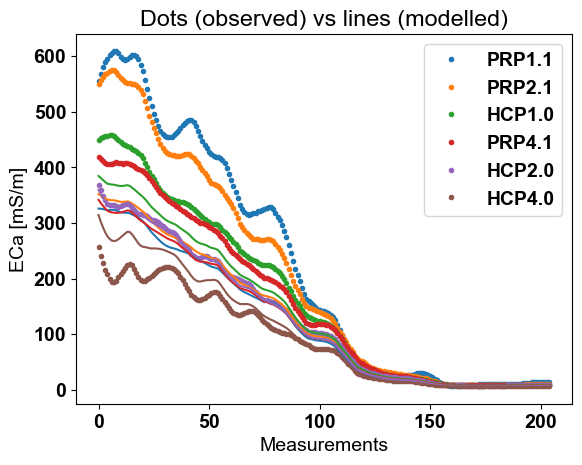

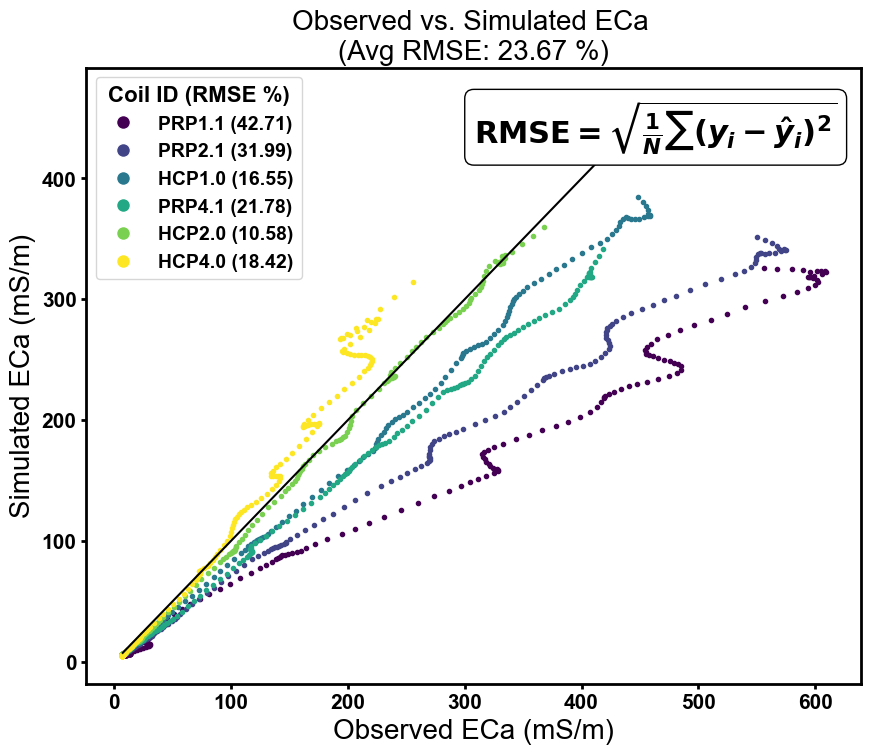

Computing DOI 1/1 done


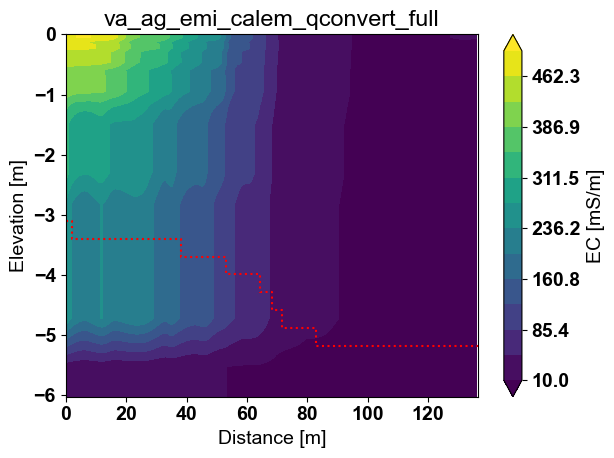

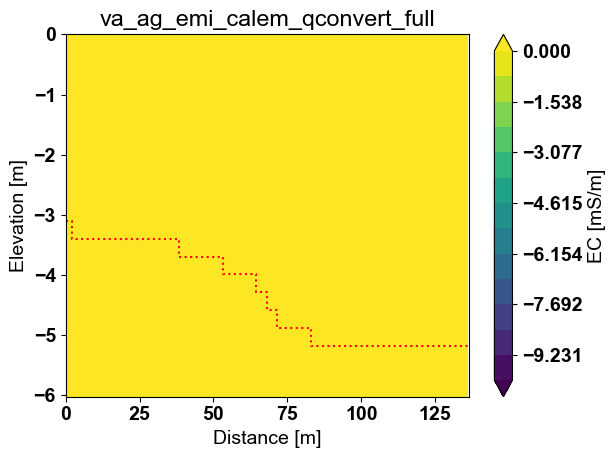

In [28]:
### RUN INVERSION

alpha = 0.03   # Vertical smoothing factor. Determined from l-curve
regularization = 'l2'    # 'l1' for blocky model, 'l2' for smooth model
threeD = False    # Peform a quasi-3D inversion where lateral smoothing is implemented via a beta value
beta = 0   # Lateral smoothing parameter (only used if threed=True and parallel=False. Increase if you want stricter lateral smoothing between adjacent profiles
parallel = True   # Only use if you're not using the quasi-3D functionality
EcaBounds = True
minEcaBound = 0
maxEcaBound = 1000
calc_doi = True    # Specify whether you want to calculate the DOI for each 1D profile after the inversion is complete. This will add a flag to the .vtk file that can be used to change
                    # visualization of measurements below the calculated DOI

bounds = []
for i in range(0, len(conds)):
    bounds.append([minEcaBound, maxEcaBound])

if solv_method == 'MCMC' or 'DREAM' or 'ANN' or 'SCUEA':
    alpha = 0
    beta = 0
    gamma = 0
    EcaBounds=False
elif solv_method == 'ROPE':
    EcaBounds=False


if parallel:
    if EcaBounds:
        k.invert(forwardModel=fwd_mdl, method=solv_method, regularization=regularization, alpha=alpha, beta=0, bnds=bounds, threed=False, njobs=-1, options={'ftol': 1e-15, 'gtol': 1e-15})
    elif solv_method == 'ROPE':
        k.invert(forwardModel=fwd_mdl, method=solv_method, regularization=regularization, alpha=alpha, beta=0, threed=False, njobs=-1, options={'maxiter': 10000})
    else:
        k.invert(forwardModel=fwd_mdl, method=solv_method, regularization=regularization, alpha=alpha, beta=0, threed=False, njobs=-1)
else:
    if EcaBounds:
        k.invert(forwardModel=fwd_mdl, method=solv_method, regularization=regularization, alpha=alpha, beta=beta, bnds=bounds, threed=threeD)
    else:
        k.invert(forwardModel=fwd_mdl, method=solv_method, regularization=regularization, alpha=alpha)

if (fwd_mdl == 'Q') | (fwd_mdl == 'QP'):
    k.showMisfit(forwardModel='FSeq')    # modeled ECa and observed ECa plotted on same axis
    k.showOne2one(index=0, forwardModel='FSeq') # modeled ECa vs observed ECa, in "Problem.py" you'll need to roll this back to the old implementation for rmses
else:
    k.showMisfit()    # modeled ECa and observed ECa plotted on same axis
    k.showOne2one(index=0) # modeled ECa vs observed ECa, in "Problem.py" you'll need to roll this back to the old implementation for rmses

if calc_doi:
    if (fwd_mdl == 'Q') | (fwd_mdl == 'QP'):
        k.computeDOI(forwardModel='FSeq', nlayers=len(depths))   # Isolate DOI for each measurement
    else:
        k.computeDOI(nlayers=len(depths))
    doi = k.dois

k.showResults(vmin = 10, vmax = 500, contour = True, cmap = 'viridis', doi=calc_doi)    # inverted EC model
k.showResults(vmin = -10, vmax = 0, contour = True, cmap = 'viridis', doi=calc_doi)    # Check for negative values
    
#SAVE INVERSION RESULTS TO CSV
#specify folder for inverted data
k.saveInvData(path)

In [33]:
### Convert EMagPy inversion result into .csv format that can be used in visualization codes

df = pd.read_csv(path + '\\' + 'inv_' + k.surveys[0].name + '.csv')  # Read inversion result

df.head()

filtDOI = False

locations = df.iloc[:, :2] 

#Strip out conductivity layers. The last number (here it is 21) 
#Should be 1 more than the number of layers (no. of layer columns) 

layers = df.iloc[:, 2:(num_layers + 3)] 

#Strip out the depth columns. Notice that the depth starting column is 
#1 more than the ending column of the layers (22). Also, we are multiplying by -1 to have a negative depth.

depth = df.iloc[:, (num_layers + 3):((num_layers*2)+3)]*-1

if calc_doi:
    df['doi'] = -doi[0]

'''
pd.melt will take a dataframe and stack the columns (from left to right) underneath each other.
A dataframe with 3 columns and 20 rows each would be converted in single column with 60 rows.
The melted dataframe has variable column (indentifying column) and a value column.
We only need the value column from each melted dataframe. (hence, layers_melt.iloc[:, 1], depth_melt.iloc[:, 1])
'''
layers_melt = pd.melt(layers)
layers_melt = layers_melt.iloc[:,1]

depth_melt = pd.melt(depth)
depth_melt = depth_melt.iloc[:,1]

if calc_doi:
    sens_full = pd.Series(np.zeros(len(layers_melt)))
    for i in range(0, num_layers+1):
        sens_full.iloc[i*len(df['doi']):(i+1)*len(df['doi'])] = df['doi']

'''
make a dictionary (dict = {'key' : value }) inside a dataframe. The dictionary key = header and value = data
'''
conduct = pd.DataFrame({'Linear Conductivity': layers_melt, 'Depth': depth_melt}).dropna()

# logcon = np.log10(conduct['Linear Conductivity'])
# conduct['Log Conductivity'] = logcon
resistivity = 1/(0.001*conduct['Linear Conductivity'])
conduct['Linear Resistivity'] = resistivity
# logres = np.log10(conduct['Linear Resistivity'])
# conduct['Log Resistivity'] = logres

conduct = conduct[['Linear Conductivity','Linear Resistivity','Depth']]

'''
The lines of code below will copy paste the X and Y locations by the number of layers you have.
If I have 11 layers, then I will multiply by 11. As seen below.
'''
x = pd.concat([locations.iloc[:,0]]*(num_layers+1), ignore_index = True)
y = pd.concat([locations.iloc[:,1]]*(num_layers+1), ignore_index = True)

'''
make a dictionary (dict = {'key' : value }) inside a dataframe. The dictionary key = header and value = data
'''
xy = pd.DataFrame({'X': x, 'Y': y})

'''
insert the X and Y into our conduct dataframe.
EVERYTIME YOU NEED TO RUN THIS CELL, YOU WILL HAVE TO RESTART YOUR KERNEL!!!!
This is because the dataframe.insert can only run once per kernel.
'''
conduct.insert(0, 'y', xy.iloc[:,1])
conduct.insert(0, 'x', xy.iloc[:,0])

if calc_doi:
    conduct['DOI'] = sens_full    # Add in column with DOI values for each 1D profile
    conduct['DOI Flag'] = np.zeros(len(conduct))   # Create a column thta indicates whether the depth of the measurement is above the DOI (0) or below it (1)
    for i in range(0, len(conduct)):
        if conduct.loc[i, 'Depth'] < conduct.loc[i, 'DOI']:
            conduct.loc[i, 'DOI Flag'] = 1
if calc_doi:
    conduct['DOI'] = sens_full    # Add in column with DOI values for each 1D profile
    conduct['DOI Flag'] = np.zeros(len(conduct))   # Create a column that indicates whether the depth of the measurement is above the DOI (0) or below it (1)
    for i in range(0, len(conduct)):
        if (conduct.loc[i, 'Depth'] < conduct.loc[i, 'DOI']) & (conduct.loc[i, 'Linear Conductivity'] > 0):
            conduct.loc[i, 'DOI Flag'] = 1
    if filtDOI:
        conduct = conduct.loc[conduct['DOI Flag'] == 0]

#SAVE PARAVIEW READY CSV
if calcQ:
    if filtDOI:
        conduct.to_csv(path + site + '_paraview_cal_inph_convert_filt_nosplit.csv', index = False)
    else:
        conduct.to_csv(path + site + '_paraview_cal_inph_convert.csv', index = False)

else:
    if filtDOI:
        conduct.to_csv(path + site + '_paraview_cal_filt.csv', index = False)
    else:
        conduct.to_csv(path + site + '_paraview_cal.csv', index = False)

In [35]:
#%% 2D Profile Visualziations

ERTcal = xyData_UTM

if filtDOI:
    emiCal = pd.read_csv(path + site + '_paraview_cal_filt.csv')
else:
    emiCal = pd.read_csv(path + site + '_paraview_cal.csv')

emiNC = pd.read_csv(path + 'va_ag_MH_paraview_nocal_inph.csv')

emiCal.rename({'Depth': 'Z'}, inplace=True)
emiNC.rename({'Depth': 'Z'}, inplace=True)


dflist = [emiCal, emiNC]  # Names of variables that will be mapped to ERI line
dfnames = ['EMIc', 'EMInc']  # Names for each entry in dflist that will be used in the column headers for the combined dataframe

for df in dflist:
    df.rename(columns={'Depth': 'Z'}, inplace=True)
mapper = er2em.DataMapper(num_neighbors=1, max_distance_xy=2, max_distance_z = 0.25, ckdMethod='num')  # Initiates testcalib.py. Adjust parameters as needed

result_xy, distances_xy = mapper.mapXYZ(ERTcal, dflist, dfnames) # Maps entries in dflist to ERTcal

for index, row in result_xy.iterrows():
    if row['Z'] < row['EMIc_DOI']:
        result_xy.loc[index, 'EMIc_DOI Flag'] = 1
    else:
        result_xy.loc[index, 'EMIc_DOI Flag'] = 0
    if row['Z'] < row['EMInc_DOI']:
        result_xy.loc[index, 'EMInc_DOI Flag'] = 1
    else:
        result_xy.loc[index, 'EMInc_DOI Flag'] = 0

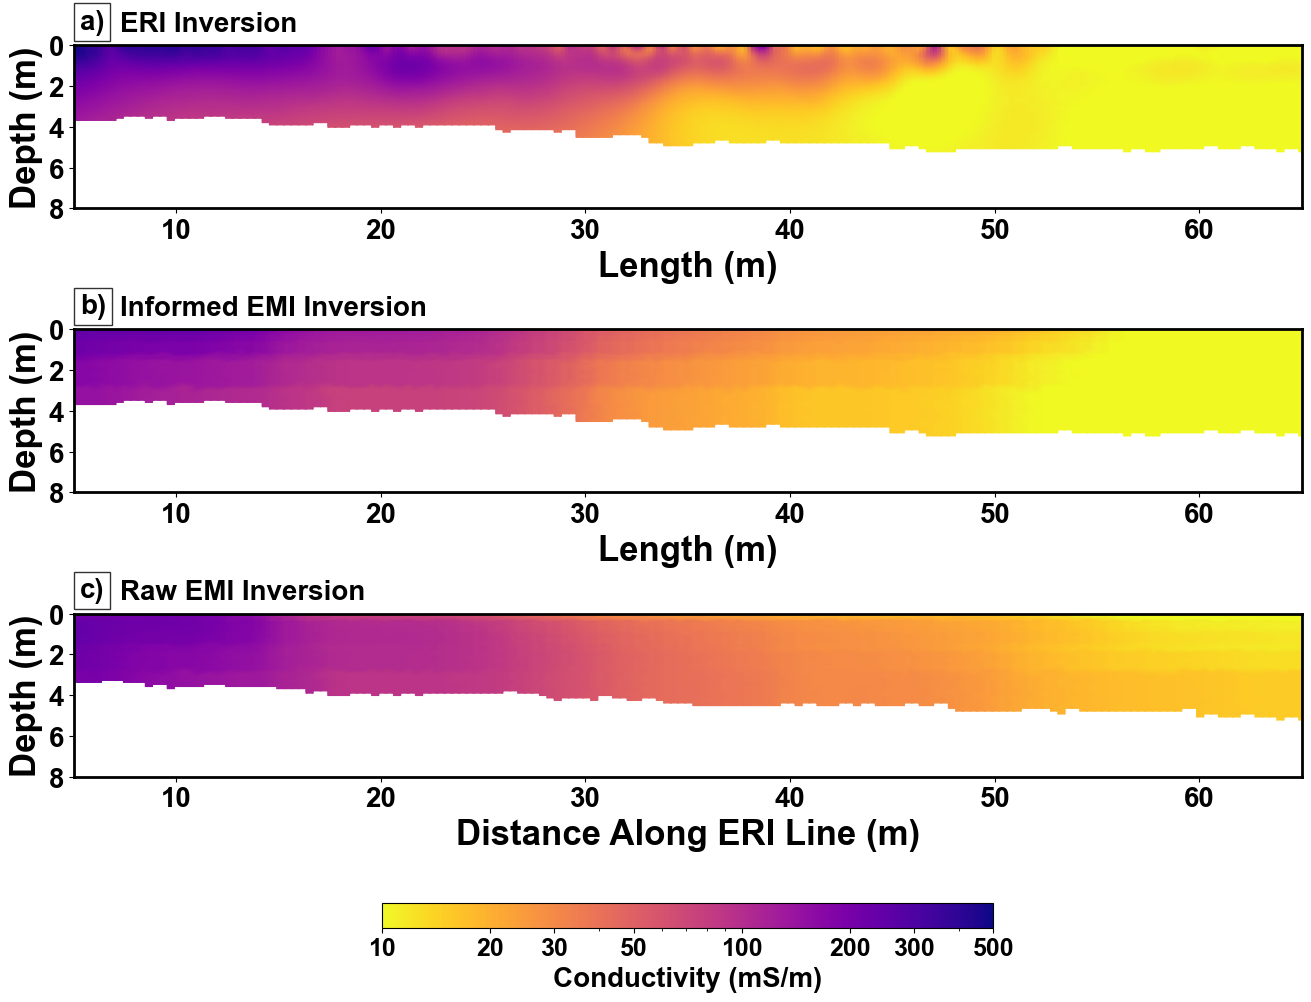

In [42]:
vmin, vmax = 10, 500  # Define Colorbar Limits
xlim_min, xlim_max = 5, 65  # Define Range of x-values in Plots
color_map = "plasma_r"   # Define colormap
num_ticks = 5   # Define number of ticks in colorbar
contourSmooth = 'smooth'   # 'smooth' for smoothed plots, 'contour' for contour plots
zBounds = [0, 8]   # Define depth bounds for plots
numZticks = 5   # Define number of ticks for depth axis
exportJointCsv = True  # If True, export result_xy as a .csv file with all rows with nan removed

ticks = [10, 20, 30, 50, 100, 200, 300, 500]

# Figure with 3 subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(13, 10), constrained_layout=True,
                         gridspec_kw={'height_ratios': [4, 4, 4]})  # Top KDE plot is thin

sf1 = 'a)'
sf2 = 'b)'
sf3 = 'c)'
sf4 = r'ERI Inversion'
sf5 = r'Informed EMI Inversion'
sf6 = r'Raw EMI Inversion'

plot_contour(axes[0], result_xy['X'], -1*result_xy['Z'],
             result_xy['Conductivity(mS/m)'], vmin, vmax,
             '', xlim_min, xlim_max, cmap=color_map, cbbool=False, cbLabel='Conductivity (mS/m)', cbTicks=ticks, ri=result_xy['EMIc_DOI Flag'], riThresh=1, dist=False, subfig=sf1, subfig2=sf4, zbounds=zBounds, numZtick=numZticks, contourOrSmooth=contourSmooth, plotMeas=False)

plot_contour(axes[1], result_xy['X'], -1*result_xy['Z'],
             result_xy['EMIc_Linear Conductivity'], vmin, vmax,
             '', xlim_min, xlim_max, cmap=color_map, cbbool=False, cbLabel='Conductivity (mS/m)', cbTicks=ticks, ri=result_xy['EMIc_DOI Flag'], riThresh=1, dist=False, subfig=sf2, subfig2=sf5, zbounds=zBounds, numZtick=numZticks, contourOrSmooth=contourSmooth, plotMeas=False)

plot_contour(axes[2], result_xy['X'], -1*result_xy['Z'],
             result_xy['EMInc_Linear Conductivity'], vmin, vmax,
             '', xlim_min, xlim_max, cmap=color_map, cbbool=True, cbLabel='Conductivity (mS/m)', cbTicks=ticks, ri=result_xy['EMInc_DOI Flag'], riThresh=1,  dist=True, subfig=sf3, subfig2=sf6, zbounds=zBounds, numZtick=numZticks, contourOrSmooth=contourSmooth, plotMeas=False)

# Save and display
plt.savefig(path + 'combined_eri_infEMI_ncEMI_plot.png", dpi=300, format="png")
plt.show()

if exportJointCsv:
    trim_result = result_xy.copy(deep=True)
    trim_result.dropna(inplace=True, subset=['EMIc_Linear Conductivity', 'EMInc_Linear Conductivity'])
    trim_result.to_csv(path + 'ERI_calEMI_ncEMI_df.csv', index=False)

             Informed (EMI vs ERI)  Raw (EMI vs ERI)
KGE_np                        0.95              0.88
KGE_2009                      0.92              0.78
KGE_2012                      0.93              0.73
NSE                           0.92              0.79
R²                            0.92              0.83
Pearson r                     0.96              0.91
Spearman r                    0.95              0.90
ME                           -0.02              0.10
MAE                           0.13              0.21
RMSE                          0.16              0.25
NRMSE_range                   0.07              0.12


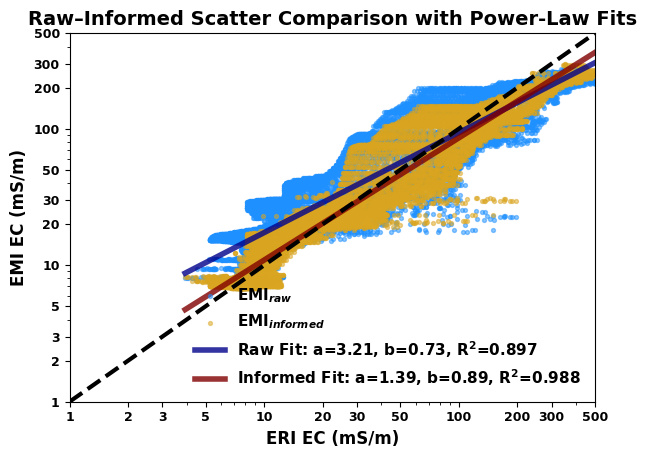

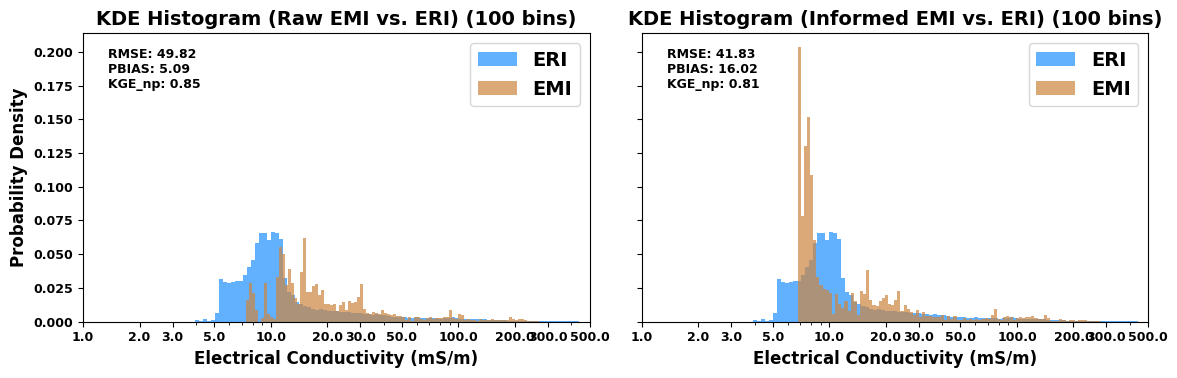

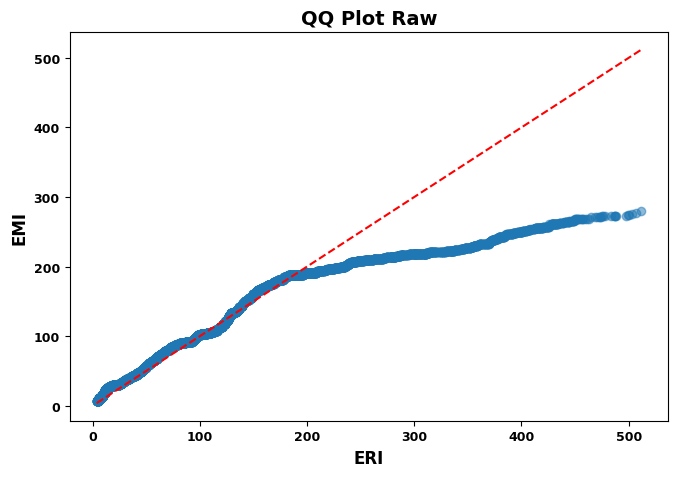

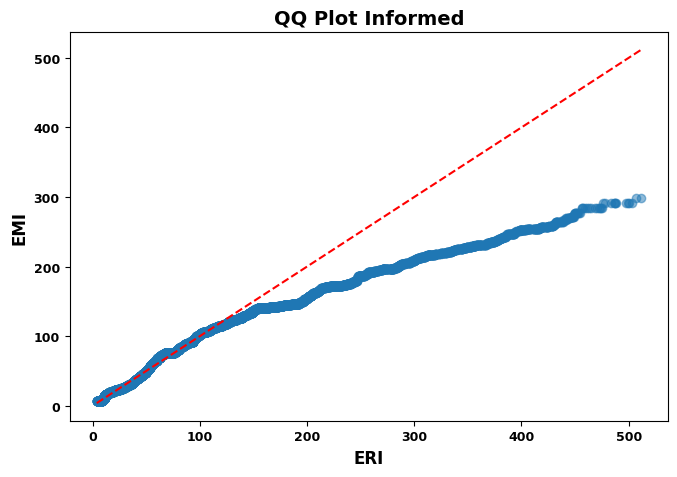

{'Mean difference': -3.75, 'Std. deviation': 49.679, 'Upper 95% limit': 93.62, 'Lower 95% limit': -101.12, 'Ratio range': '0.00× – 45580277522547045749317290228720718577664.00× ER'}
{'Mean difference': -11.8, 'Std. deviation': 40.13, 'Upper 95% limit': 66.854, 'Lower 95% limit': -90.455, 'Ratio range': '0.00× – 108275434741100103469516193792.00× ER'}


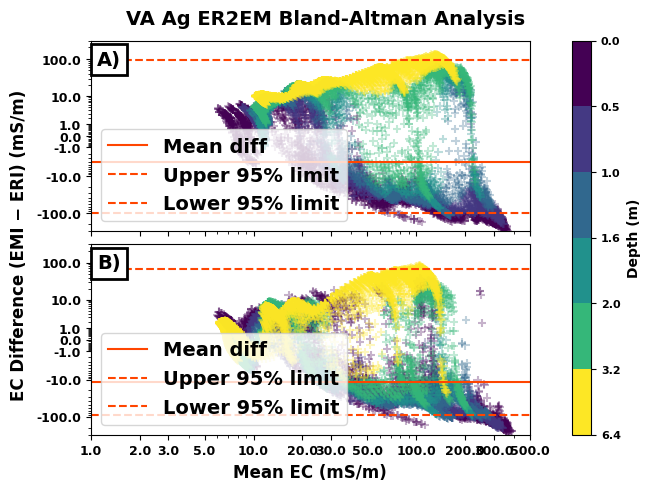

In [43]:
### Statistical Analysis

site = 'va_ag_er2em'  # Site shorthand to use for file naming

figdir = path  #  Directory where the figures will be saved to

ticks = [1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 300, 500]   # Ticks to be used for all EC axes

logList = [1, 1]   # List dictating whether to use log (1) or linear (0) scales for the Bland-Altman plots

fontkwDict = {'fontfamily': 'sans-serif',
              'fontweight': 'bold',
              'titlefontsize': titleFontKws['fontsize'],
              'titlefontweight': titleFontKws['fontweight'],
              'axislabelsize': labelFontKws['fontsize'],
              'axislabelweight': labelFontKws['fontweight'],
              'axisticksize': tickLabelFontKws['labelsize'],
              'cbartitlesize': cbarTitleKws['fontsize'],
              'cbartitleweight': cbarTitleKws['fontweight'],
              'cbarticklabelsize': cbarTickKws['fontsize']}

j = vse.EConfluxStats(csvDir + 'ERI_calEMI_ncEMI_df.csv', 'Conductivity(mS/m)', 'EMInc_Linear Conductivity', 'EMIc_Linear Conductivity', drop_flag_col=None, 
             informingMethod='ERI', informedMethod='EMI', units='mS/m', ticks=ticks, **fontkwDict)

# Get metrics table
print(j.metrics(logOrlin='log'))

# Make plots

dbounds = [0, 0.5, 1.0, 1.6, 2.0, 3.2, 6.4]
cmap = 'viridis'

j.scatter_plots(log=True, grayscale=False, figname=figdir + site + '_scatter.png')

j.kde_histograms(figname=figdir + site + '_kde.png', nbins=100)

j.qq_plot(j.X, j.y, xlabel="ER", ylabel="Raw EM", title="QQ Plot Raw", figname=figdir + site + '_rawQQ.png')

j.qq_plot(j.X, j.Y, xlabel="ER", ylabel="Informed EM", title="QQ Plot Informed", figname=figdir + site + '_infQQ.png')

### Bland-Altman Plots ###
fig, axs = plt.subplots(2, 1, sharex=True, layout='constrained', savefig=False)

# Bland-Altman for raw EM vs ER
raw_ba = j.bland_altman(j.y, j.X, ax=axs[0], ymin=-300, ymax=300, xmin=None, xmax=None, figname=None, cbar=False, dcolor=True, dbnds=dbounds, dcmap=cmap, xticks=ticks, logList=logList, legendParams={'plot': True, 'loc': 'lower left'})
print(raw_ba)

# Bland-Altman for informed EM vs ER
informed_ba = j.bland_altman(j.Y, j.X, ax=axs[1], ymin=-300, ymax=300, xmin=None, xmax=None, figname=None, cbar=False, dcolor=True, dcmap=cmap, dbnds=dbounds, xticks=ticks, logList=logList, legendParams={'plot': True, 'loc': 'lower left'}, savefig=False)
print(informed_ba)

# Bland-Altman Plot Detailing
if dbounds is not None:
    if plt.get_cmap(cmap).N == 256:
        dcmap = plt.get_cmap(cmap, len(dbounds))
    norm = colors.BoundaryNorm(dbounds, ncolors=len(dbounds))
else:
    norm = colors.Normalize(vmin=0, vmax=abs(j.data['Z'].min()))
            
cmmapable = cm.ScalarMappable(norm, dcmap)

fig.suptitle('VA Ag ER2EM Bland-Altman Analysis', **titleFontKws)
axs[0].set_xlabel('')
axs[0].set_ylabel('')

props = dict(boxstyle='square', facecolor='white', lw=2)
axs[0].text(0.014, 0.95, 'A)', transform=axs[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axs[1].set_ylabel('')
axs[1].text(0.014, 0.95, 'B)', transform=axs[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
fig.supylabel("EC Difference " + f"({j.informedMethod} − {j.informingMethod}) ({j.units})", **labelFontKws)
cb = plt.colorbar(cmmapable, ax=axs[:], location='right', orientation='vertical', boundaries=dbounds)
cb.ax.invert_yaxis()
cb.set_label('Depth (m)', **j.cbarTitleKws)
cb.ax.tick_params(axis='y', labelsize=j.cbarTickKws['fontsize'])

plt.savefig(figdir + site + '_blandaltman.png', dpi=300)